# Load Packages

In [1]:
import pandas as pd
import numpy as np
import json
import re
import csv
import matplotlib.pyplot as plt 
import seaborn as sns
from tqdm import tqdm
import ast
import os
from os import path
from pandas.plotting import table
import nltk
nltk.download("popular")
from google.colab import output
from nltk import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import string
output.clear()

%matplotlib inline
pd.set_option('display.max_colwidth', 300)

# Load Data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
load_path = '/content/drive/MyDrive/NLP_Project/data/clean/'
sentence_df = pd.read_pickle(load_path + 'anime_df.pkl')

# Seperate Sentences

In [5]:
sentence_df['Description'] = sentence_df['Description'].apply(sent_tokenize)

In [6]:
start_token = '<START>'
end_token = '<END>'
unknown_token = '<UNK>'
tokenizer_filter = '!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n'
sent_threshold = 3

half_space = ['\xa0', '\u200c', '\u200f', '\u200e', '\u200a', '\\u200c', '\\xa0', '\xad' ]
hspace = re.compile("|".join(half_space))
stop_words = re.compile(r'\b(?:%s)\b' % '|'.join(stopwords.words('english')))
punctuation = re.compile(r'[]!"$%&\'«»؟؛()<>()*،٫+,…./:–;=#@?[\\^_`{|}~-]+’’')
exclude = set(string.punctuation)
punctuation_regex = re.compile('[%s]' % re.escape(string.punctuation))

pattern = re.compile(r'([؟!\?]+|\d[\d\.:\/\\]+\d|[:\.،؛»\]\)\}"«\[\(\{])') 
cleanr = re.compile('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
# numbers = re.compile('^\d+\s|\s\d+\s|\s\d+$')
numbers = re.compile(r'([۱۲۳۴۵۶۷۸۹1234567890۰]+(\.[۱۲۳۴۵۶۷۸۹1234567890۰]+)?)')
spaces = re.compile(r"\s\s+")
NUM = '<NUM>'
NUMS = ' <NUM> '


def clean_sentences(sentences):
  def isEnglish(s):
    if s == NUM:
      return True
    try:
        s.encode(encoding='utf-8').decode('ascii')
    except UnicodeDecodeError:
        return False
    return True

  
  if len(sentences) < sent_threshold:
    return np.nan

  collection = []
  for sent in sentences:

    sent = sent.lower()
    
    # Remove punctuation
    sent = pattern.sub(r' \1 ', sent.replace('\n', ' ').replace('\t', ' '))
    sent = re.sub(punctuation, " ", sent)
    sent = re.sub(punctuation_regex, " ", sent)
    sent = re.sub(r'[^\w\s]','', sent)

    # Remove stopwords
    sent = re.sub(stop_words, '', sent)

    # HTML tags
    sent = re.sub(cleanr, ' ', sent)

    # Half spaces
    sent = re.sub(hspace, ' ', sent)

    # Numbers
    sent = re.sub(numbers, NUMS, sent)
    
    # Consecutive spaces
    sent = re.sub(spaces, ' ', sent)
    sent = sent.strip()

    sent = " ".join(list(filter(isEnglish, sent.split())))

    # Add start and end token
    # sent = " ".join([start_token, sent, end_token])
    # sent = start_token + " " + " ".join(sent) + " " + end_token
    
    if len(sent)> 1:
      collection.append(sent)

  if len(collection) < sent_threshold:
    return np.nan

  return collection


In [7]:
sentence_df['Description'] = sentence_df['Description'].apply(clean_sentences)

In [8]:
sentence_df = sentence_df.dropna(subset=['Description', 'Tags'])

In [9]:
# sentence_df.count

<bound method DataFrame.count of                                                          Title  ...                                                                                                                                                                                                                Tags
0                             Attack on Titan The Final Season  ...                                       ['Action', 'Drama', 'Fantasy', 'Horror', 'Shounen', 'Dark Fantasy', 'Military', 'War', 'Explicit Violence', 'Mature Themes', 'Physical Abuse', 'Suicide', 'Based on a Manga']
1                             Fullmetal Alchemist: Brotherhood  ...  ['Action', 'Adventure', 'Drama', 'Fantasy', 'Mystery', 'Shounen', 'Conspiracy', 'Death of a Loved One', 'Military', 'Siblings', 'Animal Abuse', 'Mature Themes', 'Violence', 'Based on a Manga', 'Domestic Abuse']
2                          Attack on Titan 3rd Season: Part II  ...                             ['Action', 'Fantasy', 'Horror',

## Visualize sentence count for each tag

In [10]:
sentence_df['Length'] = sentence_df['Description'].apply(len)

In [11]:
popular_threshold = 12

def seperate_tags(input_df):

  def replace_tag(tags):
    new_tags = []
    for t in tags:
      if t == 'Sci-Fi':
        new_tags.append('Sci Fi')
      elif t == 'BL':
        new_tags.append('Yaoi')
      else:
        new_tags.append(t)

    return new_tags

  df = input_df.copy()
  df['Tags'] = df['Tags'].apply(ast.literal_eval)
  df['Tags'] = df['Tags'].apply(replace_tag)
  df['Tags'] = df['Tags'].apply(set)
  df['Tags'] = df['Tags'].apply(list)

  df = df.explode('Tags')

  group_df = df.groupby('Tags')

  # group_df2 = df.drop(['Length', 'Title'], axis = 1)
  # group_df2 = group_df2.reset_index(drop=True)
  # group_df2 = group_df2.groupby('Tags')

  b = df.groupby('Tags')['Length'].agg('sum').reset_index(name='Counts')
  b.sort_values(by=['Counts'], inplace=True, ascending=False)

  popular_tags = list(b['Tags'][:popular_threshold])
  
  tags = []
  values = []
  counts = []
  for tag, tag_df in group_df:
    if tag in popular_tags:
      dd = tag_df['Description'].values.tolist()
      tags.append(tag)
      values.append(dd)
      counts.append(int(b[b['Tags'] == tag]['Counts']))


  # create dataframe
  sentence_level_df = pd.DataFrame({'Genre': tags, 
                                    'Description': values,
                                    'Counts' : counts})
  
  all_genres_df = pd.DataFrame({'Genre': tags, 
                                'Count': counts})

  g = all_genres_df.nlargest(columns="Count", n = 50) 
  plt.figure(figsize=(12,15)) 
  ax = sns.barplot(data=g, x= "Count", y = "Genre") 
  plt.savefig("Sentence-Count.png")
  plt.show()

  return sentence_level_df, all_genres_df, b

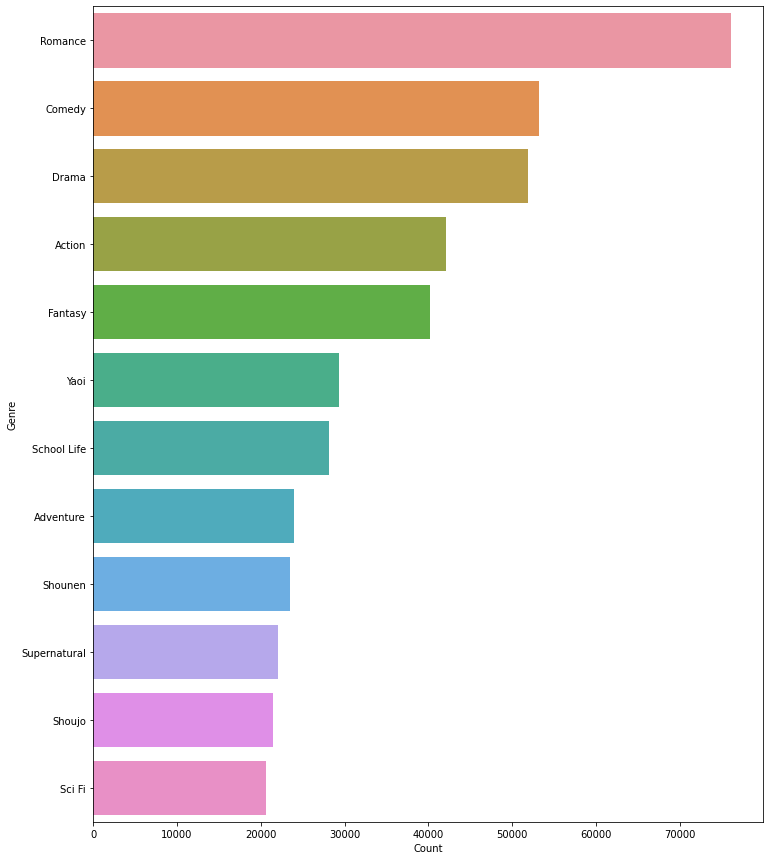

In [12]:
sentence_level_df, sentence_count_df, all_genre = seperate_tags(sentence_df)

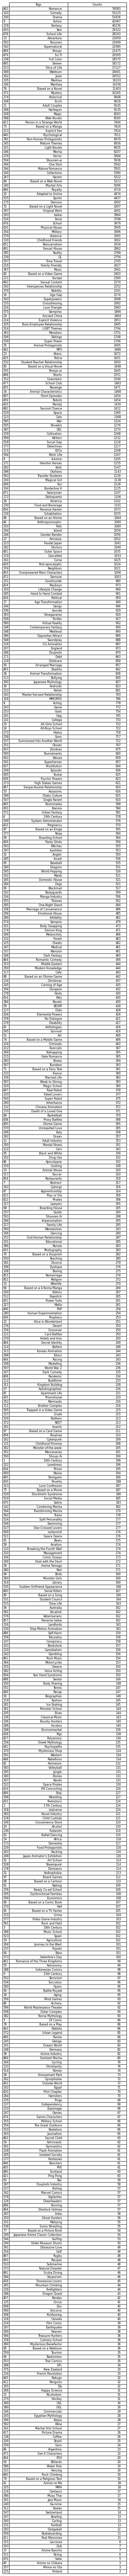

In [13]:
# all_genre

ax = plt.subplot(111, frame_on=False) # no visible frame
ax.xaxis.set_visible(False)  # hide the x axis
ax.yaxis.set_visible(False)  # hide the y axis

table(ax, all_genre, loc='center')  # where df is your data frame

x = plt.gcf()
x.savefig('all_genre_count_df.png')

In [14]:
sentence_level_df.count

<bound method DataFrame.count of            Genre  ... Counts
0         Action  ...  42067
1      Adventure  ...  23959
2         Comedy  ...  53225
3          Drama  ...  51836
4        Fantasy  ...  40236
5        Romance  ...  76083
6    School Life  ...  28163
7         Sci Fi  ...  20595
8         Shoujo  ...  21475
9        Shounen  ...  23499
10  Supernatural  ...  22080
11          Yaoi  ...  29322

[12 rows x 3 columns]>

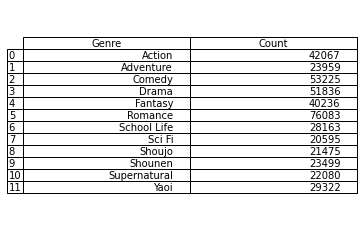

In [15]:
# sentence_count_df.count

ax = plt.subplot(111, frame_on=False) # no visible frame
ax.xaxis.set_visible(False)  # hide the x axis
ax.yaxis.set_visible(False)  # hide the y axis

table(ax, sentence_count_df, loc='center')  # where df is your data frame

plt.savefig('genre_count_df.png', bbox_inches='tight')

# Save Data

In [ ]:
save_path = '/content/drive/MyDrive/NLP_Project/data/sentence_broken/'
if not path.exists(save_path):
  os.mkdir(save_path)

sentence_count_df.to_pickle('sentence_count_df.pkl')
sentence_level_df.to_pickle('sentence_level_df.pkl')
sentence_df.to_pickle('sentence_df.pkl')

!cp /content/sentence_count_df.pkl /content/drive/MyDrive/NLP_Project/data/sentence_broken
!cp /content/sentence_level_df.pkl /content/drive/MyDrive/NLP_Project/data/sentence_broken
!cp /content/sentence_df.pkl /content/drive/MyDrive/NLP_Project/data/sentence_broken